# ESM3
ESM3 is a frontier generative model for biology, able to jointly reason across three fundamental biological properties of proteins: sequence, structure, and function. These three data modalities are represented as tracks of discrete tokens at the input and output of ESM3. You can present the model with a combination of partial inputs across the tracks, and ESM3 will provide output predictions for all the tracks.

ESM3 is a generative masked language model. You can prompt it with partial sequence, structure, and function keywords, and iteratively sample masked positions until all positions are unmasked. This iterative sampling is what the `.generate()` function does.

<!-- 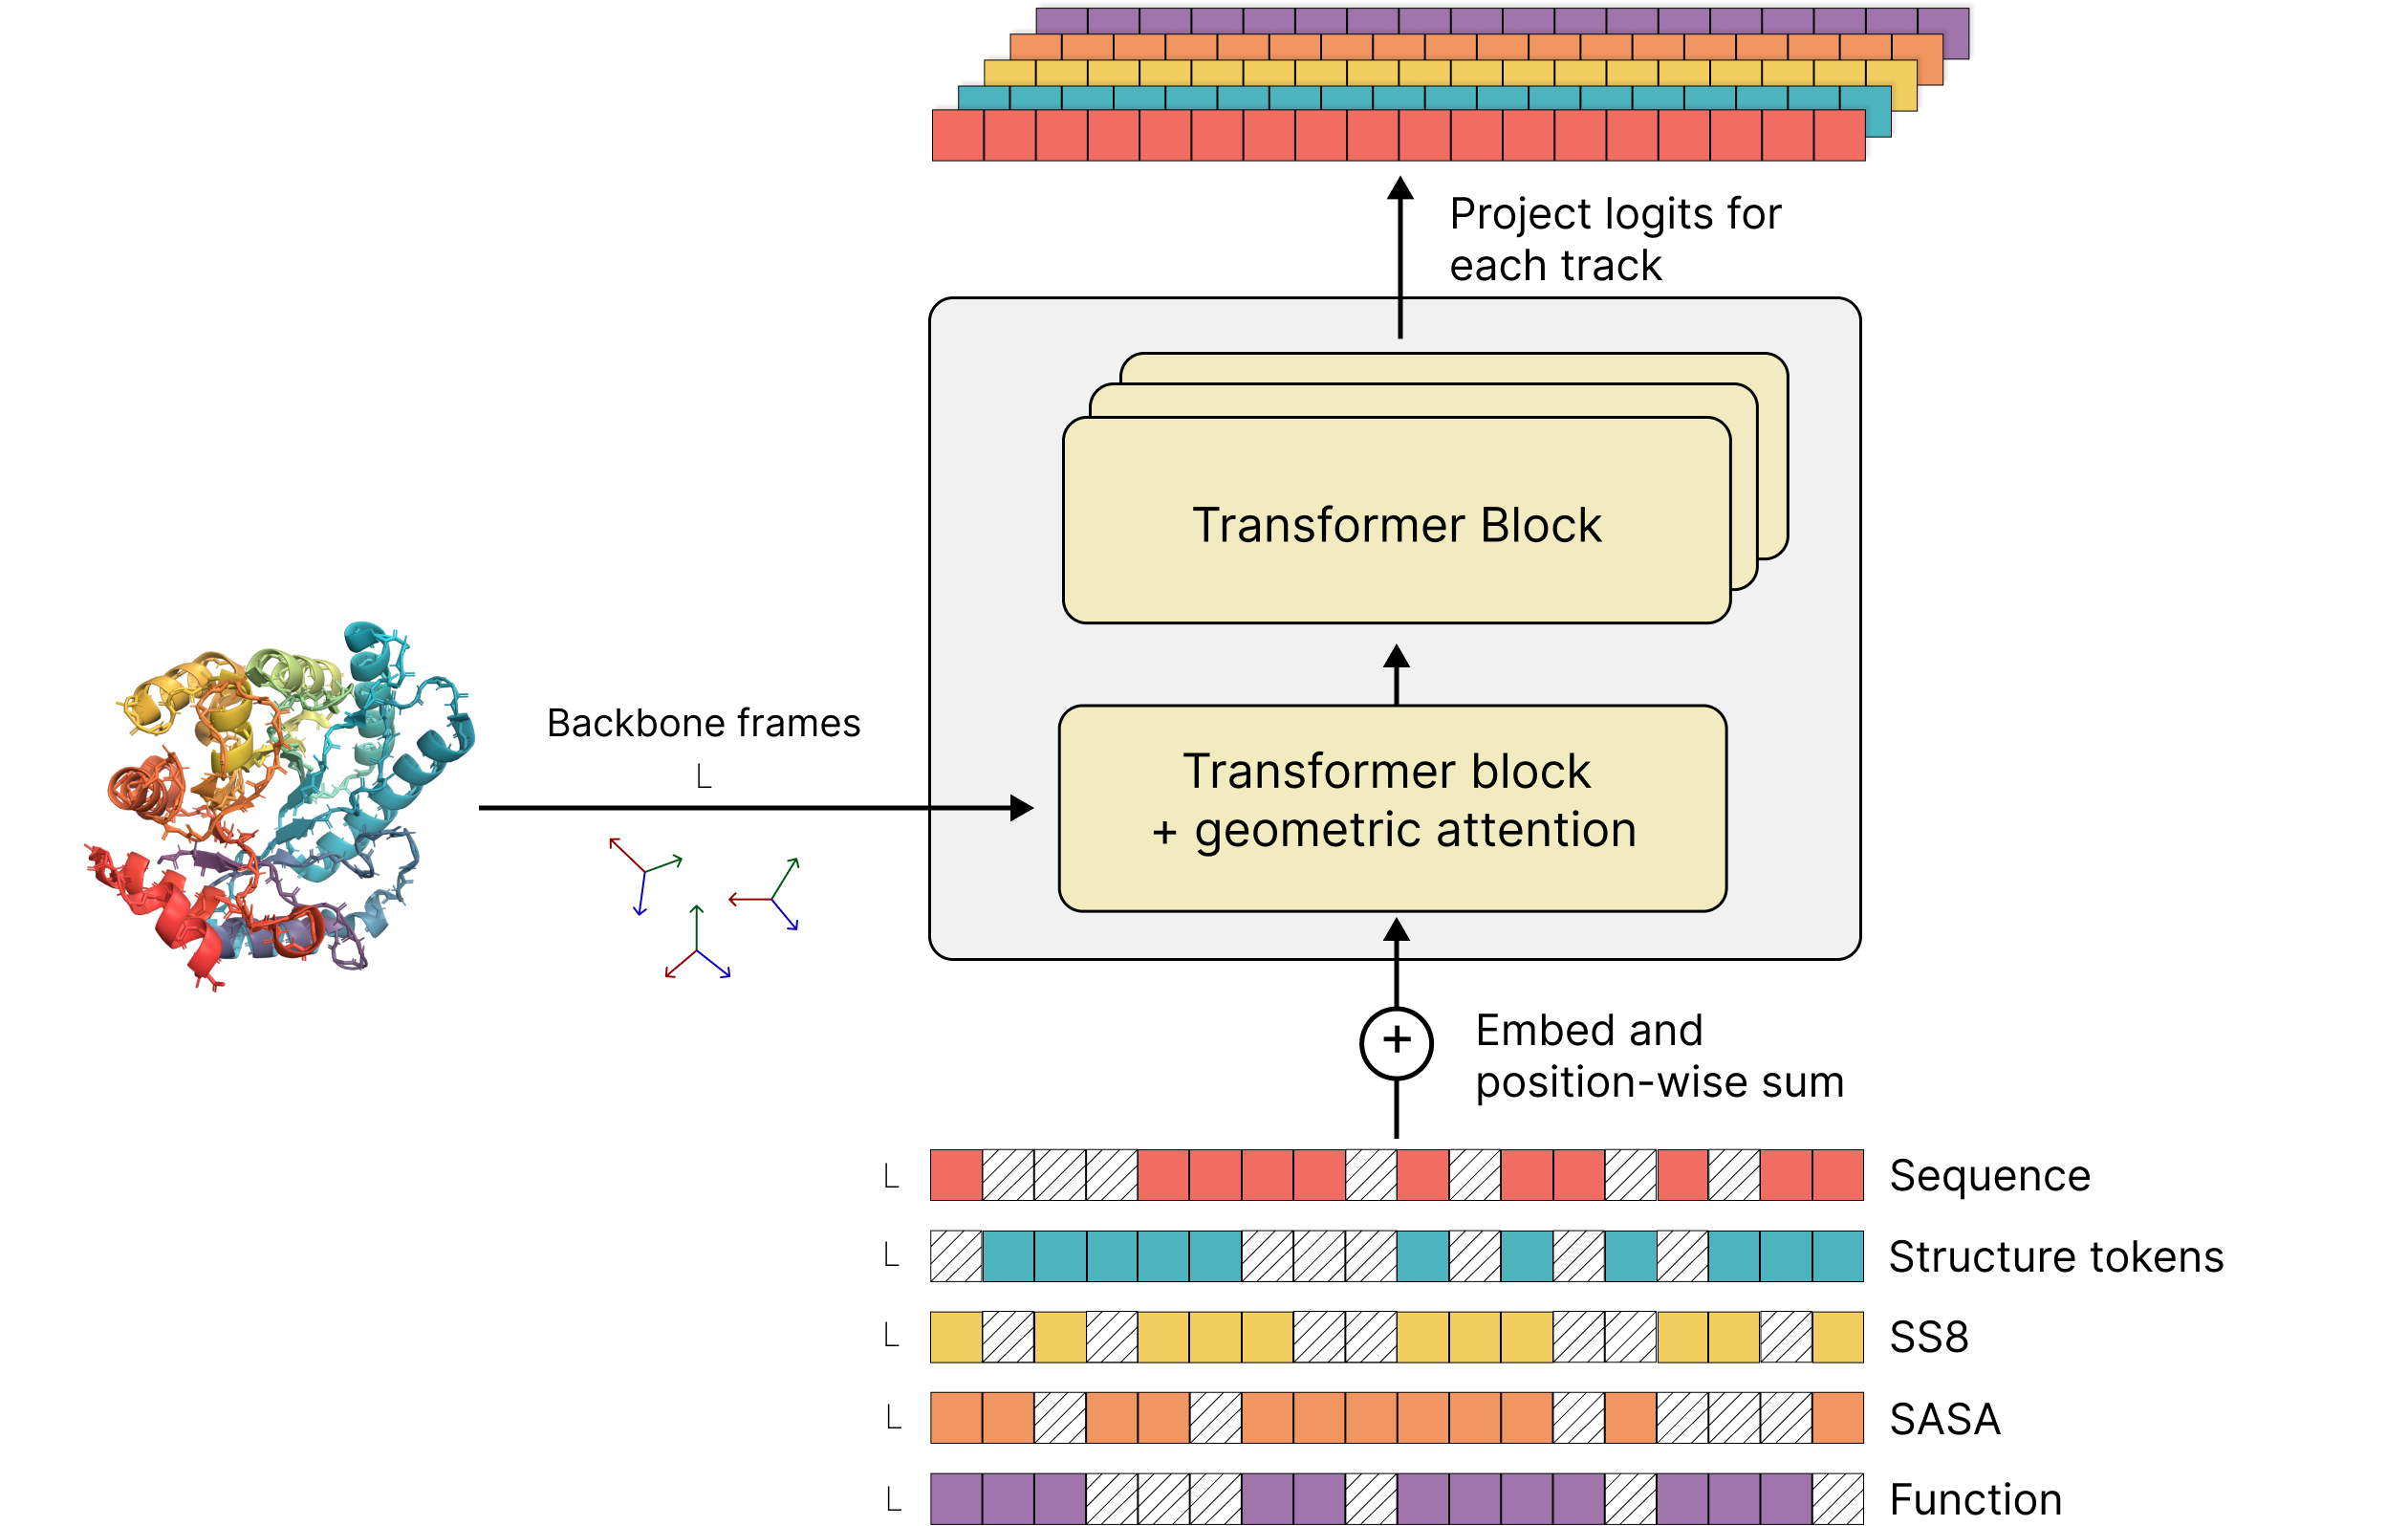 -->

The ESM3 architecture is highly scalable due to its transformer backbone and all-to-all reasoning over discrete token sequences. At its largest scale, ESM3 was trained with 1.07e24 FLOPs on 2.78 billion proteins and 771 billion unique tokens, and has 98 billion parameters.
Here we present `esm3-open-small`. With 1.4B parameters it is the smallest and fastest model in the family, trained specifically to be open sourced. ESM3-open is available under a non-commercial license.

# Imports

In [ ]:
%set_env TOKENIZERS_PARALLELISM=false
!pip install esm
import numpy as np
import torch
!pip install py3Dmol
import py3Dmol
from huggingface_hub import login

from esm.utils.structure.protein_chain import ProteinChain
from esm.models.esm3 import ESM3
from esm.sdk.api import (
    ESMProtein,
    GenerationConfig,
)

#  Load `esm-open-small` on GPU

In [ ]:
login(token="YOUR_TOKEN_HERE")
model =  ESM3.from_pretrained("esm3_sm_open_v1", device=torch.device("cuda"))

# Let's construct a prompt for ESM3, focusing on the task of scaffolding a motif from a natural protein

First, we can use the `ProteinChain` class from the `esm` sdk to grab a protein structure from the PDB

In [ ]:
pdb_id = "1ITU" # PDB ID corresponding to Renal Dipeptidase
chain_id = "A" # Chain ID corresponding to Renal Dipeptidase in the PDB structure
renal_dipep_chain = ProteinChain.from_rcsb(pdb_id, chain_id)
# Alternatively, we could have used ProteinChain.from_pdb() to load a protein structure from a local PDB file

The `ProteinChain` class is a object that makes it easy to work with protein structures. It contains a `sequence` attribute that contains the amino acid sequence of the protein


In [ ]:
print(renal_dipep_chain.sequence)

`ProteinChain` also contains an `atom37_positions` numpy array that contains the atomic coordinates of each of the residues in the protein. 

The shape of the array is `(n_residues, 37, 3)` where `n_residues` is the number of residues in the protein and 37 is the number of possible distinct atoms that may be present across all amino acids (e.g. the first three atoms are the N, C-alpha, and C atoms corresponding to the protein backbone). The 3 corresponds to the x, y, and z coordinates of each atom. The atom37 representation of protein structure allows us to use a single format to conveniently represent all amino acids -- **coordinates are only present for the atoms that are present in the amino acid and `nan` otherwise**.

In [ ]:
print("atom37_positions shape: ", renal_dipep_chain.atom37_positions.shape)
print(renal_dipep_chain.atom37_positions[:3])

We can visualize the protein chain using the `py3Dmol` library

In [ ]:
# First we can create a `py3Dmol` view object
view = py3Dmol.view(width=500, height=500)
# py3Dmol requires the atomic coordinates to be in PDB format, so we convert the `ProteinChain` object to a PDB string
pdb_str = renal_dipep_chain.to_pdb_string()
# Load the PDB string into the `py3Dmol` view object
view.addModel(pdb_str, "pdb")
# Set the style of the protein chain
view.setStyle({"cartoon": {"color": "spectrum"}})
# Zoom in on the protein chain
view.zoomTo()
# Display the protein chain
view.show()

Now, let's try to scaffold a motif from this protein using ESM3 -- we'll prompt the model with the sequence and structure of a helix-coil motif from renal dipeptidase and have the model generate a larger scaffold that includes the motif

In [ ]:
motif_inds = np.arange(123, 146)
# `ProteinChain` objects can be indexed like numpy arrays to extract the sequence and atomic coordinates of a subset of residues
motif_sequence = renal_dipep_chain[motif_inds].sequence
motif_atom37_positions = renal_dipep_chain[motif_inds].atom37_positions
print("Motif sequence: ", motif_sequence)
print("Motif atom37_positions shape: ", motif_atom37_positions.shape)

We can also visualize the motif in the original chain using `py3Dmol`. We'll color the original chain in grey and the motif in blue

In [ ]:
view = py3Dmol.view(width=500, height=500)
view.addModel(pdb_str, "pdb")
view.setStyle({"cartoon": {"color": "lightgrey"}})
motif_res_inds = (motif_inds + 1).tolist() # residue indices are 1-indexed in PDB files, so we add 1 to the indices
view.addStyle({"resi": motif_res_inds}, {"cartoon": {"color": "cyan"}})
view.zoomTo()
view.show()

Now, we can use the `ESMProtein` class to construct a prompt that will instruct ESM3 to scaffold the motif

In [ ]:
prompt_length = 200
# First, we can construct a sequence prompt of all masks
sequence_prompt = ["_"]*prompt_length
# Then, we can randomly insert the motif sequence into the prompt (we randomly choose 72 here)
sequence_prompt[72:72+len(motif_sequence)] = list(motif_sequence)
sequence_prompt = "".join(sequence_prompt)
print("Sequence prompt: ", sequence_prompt)
print("Length of sequence prompt: ", len(sequence_prompt))

# Next, we can construct a structure prompt of all nan coordinates
structure_prompt = torch.full((prompt_length, 37, 3), np.nan)
# Then, we can insert the motif atomic coordinates into the prompt, starting at index 72
structure_prompt[72:72+len(motif_atom37_positions)] = torch.tensor(motif_atom37_positions)
print("Structure prompt shape: ", structure_prompt.shape)
print("Indices with structure conditioning: ", torch.where(~torch.isnan(structure_prompt).any(dim=-1).all(dim=-1))[0].tolist())

# Finally, we can use the ESMProtein class to compose the sequence and structure prompts into a single prompt that can be passed to ESM3
protein_prompt = ESMProtein(sequence=sequence_prompt, coordinates=structure_prompt)

Now, we can use the `generate` method of the model to iteratively sample a protein sequence based on the prompt. Under the hood, the model performs num_steps forward passes and samples a set of tokens at each step until the chosen track being generated is fully unmasked. 

In [ ]:
# We'll have to first construct a `GenerationConfig` object that specifies the decoding parameters that we want to use
sequence_generation_config = GenerationConfig(
    track="sequence", # We want ESM3 to generate tokens for the sequence track
    num_steps=sequence_prompt.count("_") // 2, # We'll use num(mask tokens) // 2 steps to decode the sequence
    temperature=0.5, # We'll use a temperature of 0.5 to control the randomness of the decoding process
)

# Now, we can use the `generate` method of the model to decode the sequence
sequence_generation = model.generate(protein_prompt, sequence_generation_config)
print("Sequence Prompt:\n\t", protein_prompt.sequence)
print("Generated sequence:\n\t", sequence_generation.sequence)

We can also use the `generate` method to predict the structure of the generated sequence by iteratively sampling structure tokens.

In [ ]:
structure_prediction_config = GenerationConfig(
    track="structure", # We want ESM3 to generate tokens for the structure track
    num_steps=len(sequence_generation) // 8,
    temperature=0.7, 
)
structure_prediction_prompt = ESMProtein(sequence=sequence_generation.sequence)
structure_prediction = model.generate(structure_prediction_prompt, structure_prediction_config)

Now, we can visualize the generated structure using `py3Dmol`. We'll visualize the generated structure (right, green) alongside the original structure (left, grey) from which the motif was drawn. The motif residues are colored in cyan.

In [ ]:
# Convert the generated structure to a back into a ProteinChain object
structure_prediction_chain = structure_prediction.to_protein_chain()
# Align the generated structure to the original structure using the motif residues
motif_inds_in_generation = np.arange(72, 72+len(motif_sequence))
structure_prediction_chain.align(renal_dipep_chain, mobile_inds=motif_inds_in_generation, target_inds=motif_inds)
crmsd = structure_prediction_chain.rmsd(renal_dipep_chain, mobile_inds=motif_inds_in_generation, target_inds=motif_inds)
print("cRMSD of the motif in the generated structure vs the original structure: ", crmsd)

view = py3Dmol.view(width=1000, height=500, viewergrid=(1, 2))
view.addModel(pdb_str, "pdb", viewer=(0, 0))
view.addModel(structure_prediction_chain.to_pdb_string(), "pdb", viewer=(0, 1))
view.setStyle({"cartoon": {"color": "lightgrey"}}, viewer=(0, 0))
view.setStyle({"cartoon": {"color": "lightgreen"}}, viewer=(0, 1))
view.addStyle({"resi": motif_res_inds}, {"cartoon": {"color": "cyan"}}, viewer=(0, 0))
view.addStyle({"resi": (motif_inds_in_generation+1).tolist()}, {"cartoon": {"color": "cyan"}}, viewer=(0, 1))
view.zoomTo()
view.show()

# Secondary Structure Editing Example: Helix Shortening

Now, we can try another generation task with ESM3. We'll use the secondary structure track, along with the sequence track, to shorten a helix-coil-helix region (residues 39-111) in a protein structure (colored in blue below)

In [ ]:
helix_shortening_chain = ProteinChain.from_rcsb("7XBQ", "A")
view = py3Dmol.view(width=500, height=500)
view.addModel(helix_shortening_chain.to_pdb_string(), "pdb")
view.setStyle({"cartoon": {"color": "lightgrey"}})
helix_region = np.arange(38, 111) # zero-indexed
view.addStyle({"resi": (helix_region + 1).tolist()}, {"cartoon": {"color":"lightblue"}})
view.zoomTo()
view.show()
helix_shortening_ss8 = "CCCSHHHHHHHHHHHTTCHHHHHHHHHHHHHTCSSCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHTTCHHHHHHHHHHHHHHHHHHHHHHHHHHHHIIIIIGGGCCSHHHHHHHHHHHHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHHHHHHHHSCTTCHHHHHHHHHHHHHIIIIICCHHHHHHHHHHHHHHHHTTCTTCCSSHHHHHHHHHHHHHHHHHHHC"
print("Secondary structure of protein: (H: Alpha Helix, E: Beta Strand, C: Coil) \n\t", helix_shortening_ss8)

The helix-coil-helix region in the original protein is 73 residues long. We will try to shorten it to 45 residues by prompting the model with partial sequence and secondary structure

In [ ]:
shortened_region_length = 45

# We'll construct a sequence prompt that masks the (shortened) helix-coil-helix region, but leaves the flanking regions unmasked
sequence_prompt = helix_shortening_chain.sequence[:helix_region[0]] + "_" * shortened_region_length + helix_shortening_chain.sequence[helix_region[-1] + 1:]
print("Sequence prompt:\n\t", sequence_prompt)

# We'll construct a secondary structure prompt that retains the secondary structure of the flanking regions, and shortens the lengths of helices in the helix-coil-helix region
ss8_prompt = helix_shortening_ss8[:helix_region[0]] + (((shortened_region_length - 3) // 2) * "H" + "C"*3 + ((shortened_region_length - 3) // 2) * "H") + helix_shortening_ss8[helix_region[-1] + 1:]
print("SS8 prompt:\n\t", ss8_prompt)
print("Proposed SS8 for shortened helix-coil-helix region:\n\t", " "*helix_region[0] + ss8_prompt[helix_region[0]:helix_region[0]+45])

print("")
print("Original sequence:\n\t", helix_shortening_chain.sequence)
print("Original SS8:\n\t", helix_shortening_ss8)
print("Original SS8 for helix-coil-helix region:\n\t", " "*helix_region[0] + helix_shortening_ss8[helix_region[0]:helix_region[-1]+1])


# We can again use the ESMProtein class to compose the sequence and secondary structure prompts into a single prompt that can be passed to ESM3
protein_prompt = ESMProtein(sequence=sequence_prompt, secondary_structure=ss8_prompt)

We can again use the `generate` method of the model to iteratively decode a protein sequence based on the prompt

In [ ]:
print("Generating protein sequence...")
sequence_generation = model.generate(protein_prompt, GenerationConfig(track="sequence", num_steps=protein_prompt.sequence.count("_") // 2, temperature=0.5))
print("Folding protein...")
structure_prediction = model.generate(ESMProtein(sequence=sequence_generation.sequence), GenerationConfig(track="structure", num_steps=len(protein_prompt) // 4, temperature=0))

Now, we can visualize the generated structure using `py3Dmol`. We'll visualize the generated structure (right) alongside the original structure (left) from which the motif was drawn. The helix-coil-helix region in the original structure is colored in blue and the shortened region in the generated structure is colored in pink.

In [ ]:
predicted_chain = structure_prediction.to_protein_chain()
predicted_chain = predicted_chain.align(helix_shortening_chain, mobile_inds=np.arange(len(predicted_chain) - 120, len(predicted_chain)), target_inds=np.arange(len(helix_shortening_chain) - 120, len(helix_shortening_chain)))
view = py3Dmol.view(width=1000, height=500, viewergrid=(1, 2))
view.addModel(helix_shortening_chain.to_pdb_string(), "pdb", viewer=(0, 0))
view.addModel(predicted_chain.to_pdb_string(), "pdb", viewer=(0, 1))
view.setStyle({"cartoon": {"color": "lightgrey"}})
view.addStyle({"resi": (helix_region + 1).tolist()}, {"cartoon": {"color":"lightblue"}},viewer=(0, 0))
view.addStyle({"resi": (np.arange(helix_region[0], helix_region[0] + 45) + 1).tolist()}, {"cartoon": {"color":"pink"}},viewer=(0, 1))
view.zoomTo()
view.show()

# SASA Editing Example: Exposing a buried helix

Let's grab 1LBS from the PDB and visualize it using `py3Dmol`. 1LBS has an alternating alpha-beta sandwich fold, with a buried helix in the center, highlighted in red

In [ ]:
lipase_chain = ProteinChain.from_rcsb("1LBS", "A")
span_start = 105
span_end = 116
view = py3Dmol.view(width=500, height=500)
view.addModel(lipase_chain.to_pdb_string(), "pdb")
view.setStyle({"cartoon": {"color": "lightgrey"}})
view.addStyle({"resi": (np.arange(span_start, span_end) + 1).tolist()}, {"cartoon": {"color":"red"}})
view.zoomTo()
view.show()
lipase_ss8 = "CCSSCCCCSSCHHHHHHTEEETTBBTTBCSSEEEEECCTTCCHHHHHTTTHHHHHHHTTCEEEEECCTTTTCSCHHHHHHHHHHHHHHHHHHTTSCCEEEEEETHHHHHHHHHHHHCGGGGGTEEEEEEESCCTTCBGGGHHHHHTTCBCHHHHHTBTTCHHHHHHHHTTTTBCSSCEEEEECTTCSSSCCCCSSSTTSTTCCBTSEEEEHHHHHCTTCCCCSHHHHHBHHHHHHHHHHHHCTTSSCCGGGCCSTTCCCSBCTTSCHHHHHHHHSTHHHHHHHHHHSCCBSSCCCCCGGGGGGSTTCEETTEECCC"

We can construct a multimodal prompt for ESM3 to instruct it to expose the buried helix as follows:
1. Prompt with the **structure** of the buried helix highlighted in red -- this will prompt ESM3 to generate a protein that contains that same helix
2. Prompt with high **SASA** values for the residues in the buried helix -- this will prompt ESM3 to expose the helix to the surface of the protein

In [ ]:
structure_prompt = torch.full((len(lipase_chain), 37, 3), torch.nan)
structure_prompt[span_start:span_end] = torch.tensor(lipase_chain[span_start:span_end].atom37_positions, dtype=torch.float32)   

sasa_prompt = [None]*len(lipase_chain)
sasa_prompt[span_start:span_end] = [40.0]*(span_end - span_start)

print("SASA prompt (just for buried region): ", sasa_prompt[span_start:span_end])

protein_prompt = ESMProtein(sequence="_"*len(lipase_chain), coordinates=structure_prompt, sasa=sasa_prompt)

This is a more difficult task, so you may need to sample more generations from ESM before you find a solution. We'll sample 32 here and sort by the generations with the highest predicted TM-score (pTM) by ESM3. 

In [ ]:
generated_proteins = []
N_SAMPLES = 32
for i in range(N_SAMPLES):
    print("Generating protein sequence...")
    sequence_generation = model.generate(protein_prompt, GenerationConfig(track="sequence", num_steps=len(protein_prompt) // 8, temperature=0.7))
    print("Folding protein...")
    structure_prediction = model.generate(ESMProtein(sequence=sequence_generation.sequence), GenerationConfig(track="structure", num_steps=len(protein_prompt) // 32))
    generated_proteins.append(structure_prediction)

# Sort generations by ptm
generated_proteins = sorted(generated_proteins, key=lambda x: x.ptm.item(), reverse=True)

Let's visualize the top 4 generations by pTM, alongside with the original protein (on the left)

In [ ]:
N_SAMPLES_TO_SHOW = 4
view = py3Dmol.view(width=1000, height=500, viewergrid=(1, N_SAMPLES_TO_SHOW+1))
view.addModel(lipase_chain.to_pdb_string(), "pdb", viewer=(0, 0))
for i in range(N_SAMPLES_TO_SHOW):
    print("PTM of generated protein {}: {:.2f}".format(i+1, generated_proteins[i].ptm.item()))
    view.addModel(generated_proteins[i].to_protein_chain().to_pdb_string(), "pdb", viewer=(0, i+1))
view.setStyle({"cartoon": {"color": "lightgrey"}})
view.addStyle({"resi": (np.arange(span_start, span_end) + 1).tolist()}, {"cartoon": {"color": "red"}})
view.zoomTo()
view.show()